In [3]:
# Setup environment
%run 0-Environment_Setup.ipynb

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Stored 's3_datalake_path_csv' (str)
Stored 'local_data_path_csv' (str)
Stored 's3_datalake_path_parquet' (str)


In [4]:
# Pull the data from the feature store sorted by date and then store number
sales_features_store_df = get_store_dataset_from_offline_feature_group_date_sort(store_sales_feature_group)
sales_features_store_df.head()

Running 
    SELECT *
    FROM
        "store_sales_feature_group_offline_1728164033"
    ORDER BY
        date ASC, store_nbr ASC
    


,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,...,month_sin,day_cos,day_sin,dow_cos,dow_sin,sales_record_id,event_time,write_time,api_invocation_time,is_deleted
0,2013-01-01,1,0.0,93.14,0,1,18,12,13,2013,...,0.5,0.97953,0.201299,0.62349,0.781831,2013-01-01:1,1.728164e+09,2024-10-05 21:39:49.912,2024-10-05 21:34:48.000,False
1,2013-01-01,2,0.0,93.14,0,1,18,12,13,2013,...,0.5,0.97953,0.201299,0.62349,0.781831,2013-01-01:2,1.728164e+09,2024-10-05 21:39:50.076,2024-10-05 21:34:48.000,False
2,2013-01-01,3,0.0,93.14,0,1,18,12,8,2013,...,0.5,0.97953,0.201299,0.62349,0.781831,2013-01-01:3,1.728164e+09,2024-10-05 21:39:49.967,2024-10-05 21:34:48.000,False
3,2013-01-01,4,0.0,93.14,0,1,18,12,9,2013,...,0.5,0.97953,0.201299,0.62349,0.781831,2013-01-01:4,1.728164e+09,2024-10-05 21:39:50.013,2024-10-05 21:34:48.000,False
4,2013-01-01,5,0.0,93.14,0,1,21,14,4,2013,...,0.5,0.97953,0.201299,0.62349,0.781831,2013-01-01:5,1.728164e+09,2024-10-05 21:39:50.068,2024-10-05 21:34:48.000,False


In [5]:
# Drop miscellaneous info
sales_features_store_df.drop(columns=["sales_record_id", "event_time", "write_time", "api_invocation_time", "is_deleted"], inplace=True)

In [6]:
sales_features_store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90936 entries, 0 to 90935
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                90936 non-null  object 
 1   store_nbr           90936 non-null  int64  
 2   sales               90936 non-null  float64
 3   oil                 90936 non-null  float64
 4   onpromotion         90936 non-null  int64  
 5   is_holiday          90936 non-null  int64  
 6   city                90936 non-null  int64  
 7   state               90936 non-null  int64  
 8   cluster             90936 non-null  int64  
 9   year                90936 non-null  int64  
 10  month               90936 non-null  int64  
 11  day                 90936 non-null  int64  
 12  dow                 90936 non-null  int64  
 13  city-state          90936 non-null  object 
 14  city-state-cluster  90936 non-null  object 
 15  hash_0              90936 non-null  float64
 16  hash

In [7]:
# Perform feature selection
def get_store_features(row):
    sales, oil, onpromotion, is_holiday, city, state, cluster, dow = row["sales"], row["oil"], row["onpromotion"], row["is_holiday"], row["city"], row["state"], row["cluster"], row["dow"]
    return [sales, oil, onpromotion, is_holiday, city, state, cluster, dow]

sales_features_store_df.head().apply(get_store_features, axis=1)

0    [0.0, 93.14, 0, 1, 18, 12, 13, 1]
1    [0.0, 93.14, 0, 1, 18, 12, 13, 1]
2     [0.0, 93.14, 0, 1, 18, 12, 8, 1]
3     [0.0, 93.14, 0, 1, 18, 12, 9, 1]
4     [0.0, 93.14, 0, 1, 21, 14, 4, 1]
dtype: object

In [8]:
# Apply to the whole dataframe
sales_features_store_df["features"] = sales_features_store_df.apply(get_store_features, axis=1)

In [9]:
# Drop everything except the store number, date, and selected features
drop_columns = [col for col in sales_features_store_df.columns if col not in ["date", "store_nbr", "features"]]
sales_features_store_df.drop(columns=drop_columns, inplace=True)
sales_features_store_df.head()

,date,store_nbr,features
0,2013-01-01,1,"[0.0, 93.14, 0, 1, 18, 12, 13, 1]"
1,2013-01-01,2,"[0.0, 93.14, 0, 1, 18, 12, 13, 1]"
2,2013-01-01,3,"[0.0, 93.14, 0, 1, 18, 12, 8, 1]"
3,2013-01-01,4,"[0.0, 93.14, 0, 1, 18, 12, 9, 1]"
4,2013-01-01,5,"[0.0, 93.14, 0, 1, 21, 14, 4, 1]"


In [10]:
# Pivot the data to be in the format (store number, date, features)
sales_data_pivoted = sales_features_store_df.pivot(index="store_nbr", columns="date", values="features")
sales_data_pivoted.head()

date,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,...,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15
store_nbr,,,,,,,,,,,,,,,,,,,,,
1,"[0.0, 93.14, 0, 1, 18, 12, 13, 1]","[7417.15, 93.14, 0, 0, 18, 12, 13, 2]","[5873.24, 92.97, 0, 0, 18, 12, 13, 3]","[5919.88, 93.12, 0, 0, 18, 12, 13, 4]","[6318.79, 93.12, 0, 1, 18, 12, 13, 5]","[2199.09, 93.12, 0, 0, 18, 12, 13, 6]","[6150.92, 93.2, 0, 0, 18, 12, 13, 0]","[5597.18, 93.21, 0, 0, 18, 12, 13, 1]","[6808.58, 93.08, 0, 0, 18, 12, 13, 2]","[4757.71, 93.81, 0, 0, 18, 12, 13, 3]",...,"[4409.25, 49.57, 29, 0, 18, 12, 13, 6]","[10538.14, 49.37, 44, 0, 18, 12, 13, 0]","[11070.76, 49.07, 35, 0, 18, 12, 13, 1]","[12583.65, 49.59, 212, 0, 18, 12, 13, 2]","[10834.58, 48.54, 31, 1, 18, 12, 13, 3]","[5403.74, 48.81, 38, 1, 18, 12, 13, 4]","[7543.62, 48.81, 28, 0, 18, 12, 13, 5]","[3902.78, 48.81, 19, 0, 18, 12, 13, 6]","[10433.31, 47.59, 30, 0, 18, 12, 13, 0]","[9823.55, 47.57, 29, 0, 18, 12, 13, 1]"
2,"[0.0, 93.14, 0, 1, 18, 12, 13, 1]","[10266.72, 93.14, 0, 0, 18, 12, 13, 2]","[7612.54, 92.97, 0, 0, 18, 12, 13, 3]","[7526.38, 93.12, 0, 0, 18, 12, 13, 4]","[9539.57, 93.12, 0, 1, 18, 12, 13, 5]","[10322.39, 93.12, 0, 0, 18, 12, 13, 6]","[6675.97, 93.2, 0, 0, 18, 12, 13, 0]","[6109.57, 93.21, 0, 0, 18, 12, 13, 1]","[6740.52, 93.08, 0, 0, 18, 12, 13, 2]","[5565.04, 93.81, 0, 0, 18, 12, 13, 3]",...,"[16987.57, 49.57, 43, 0, 18, 12, 13, 6]","[12382.45, 49.37, 39, 0, 18, 12, 13, 0]","[11304.55, 49.07, 38, 0, 18, 12, 13, 1]","[12615.75, 49.59, 213, 0, 18, 12, 13, 2]","[11317.83, 48.54, 26, 1, 18, 12, 13, 3]","[13081.77, 48.81, 57, 1, 18, 12, 13, 4]","[12382.42, 48.81, 33, 0, 18, 12, 13, 5]","[13766.82, 48.81, 32, 0, 18, 12, 13, 6]","[12211.46, 47.59, 36, 0, 18, 12, 13, 0]","[11196.26, 47.57, 33, 0, 18, 12, 13, 1]"
3,"[0.0, 93.14, 0, 1, 18, 12, 8, 1]","[24060.35, 93.14, 0, 0, 18, 12, 8, 2]","[18570.75, 92.97, 0, 0, 18, 12, 8, 3]","[17392.1, 93.12, 0, 0, 18, 12, 8, 4]","[22700.87, 93.12, 0, 1, 18, 12, 8, 5]","[25343.62, 93.12, 0, 0, 18, 12, 8, 6]","[17036.25, 93.2, 0, 0, 18, 12, 8, 0]","[14220.42, 93.21, 0, 0, 18, 12, 8, 1]","[14735.15, 93.08, 0, 0, 18, 12, 8, 2]","[12222.91, 93.81, 0, 0, 18, 12, 8, 3]",...,"[42005.37, 49.57, 43, 0, 18, 12, 8, 6]","[32074.15, 49.37, 41, 0, 18, 12, 8, 0]","[28450.84, 49.07, 40, 0, 18, 12, 8, 1]","[32962.39, 49.59, 222, 0, 18, 12, 8, 2]","[26035.93, 48.54, 30, 1, 18, 12, 8, 3]","[32885.76, 48.81, 67, 1, 18, 12, 8, 4]","[31903.48, 48.81, 34, 0, 18, 12, 8, 5]","[34845.12, 48.81, 36, 0, 18, 12, 8, 6]","[32843.7, 47.59, 34, 0, 18, 12, 8, 0]","[30185.6, 47.57, 33, 0, 18, 12, 8, 1]"
4,"[0.0, 93.14, 0, 1, 18, 12, 9, 1]","[10200.08, 93.14, 0, 0, 18, 12, 9, 2]","[7400.25, 92.97, 0, 0, 18, 12, 9, 3]","[6902.05, 93.12, 0, 0, 18, 12, 9, 4]","[9948.38, 93.12, 0, 1, 18, 12, 9, 5]","[11679.69, 93.12, 0, 0, 18, 12, 9, 6]","[6748.2, 93.2, 0, 0, 18, 12, 9, 0]","[6017.61, 93.21, 0, 0, 18, 12, 9, 1]","[5867.88, 93.08, 0, 0, 18, 12, 9, 2]","[4674.25, 93.81, 0, 0, 18, 12, 9, 3]",...,"[16801.05, 49.57, 32, 0, 18, 12, 9, 6]","[10214.14, 49.37, 29, 0, 18, 12, 9, 0]","[9760.27, 49.07, 32, 0, 18, 12, 9, 1]","[10671.73, 49.59, 198, 0, 18, 12, 9, 2]","[8623.36, 48.54, 24, 1, 18, 12, 9, 3]","[10819.54, 48.81, 54, 1, 18, 12, 9, 4]","[10622.3, 48.81, 30, 0, 18, 12, 9, 5]","[13065.9, 48.81, 28, 0, 18, 12, 9, 6]","[10911.89, 47.59, 29, 0, 18, 12, 9, 0]","[9709.09, 47.57, 31, 0, 18, 12, 9, 1]"
5,"[0.0, 93.14, 0, 1, 21, 14, 4, 1]","[10598.62, 93.14, 0, 0, 21, 14, 4, 2]","[7770.97, 92.97, 0, 0, 21, 14, 4, 3]","[7347.64, 93.12, 0, 0, 21, 14, 4, 4]","[8192.6, 93.12, 0, 1, 21, 14, 4, 5]","[10843.23, 93.12, 0, 0, 21, 14, 4, 6]","[6468.32, 93.2, 0, 0, 21, 14, 4, 0]","[6427.86, 93.21, 0, 0, 21, 14, 4, 1]","[6057.11, 93.08, 0, 0, 21, 14, 4, 2]","[5950.81, 93.81, 0, 0, 21, 14, 4, 3]",...,"[11264.56, 49.57, 37, 0, 21, 14, 4, 6]","[10011.66, 49.37, 42, 0, 21, 14, 4, 0]","[7868.12, 49.07, 3

In [11]:
# Convert the data to an array
stacked_sales_data = np.array(sales_data_pivoted.values.tolist())
stacked_sales_data.shape

(54, 1684, 8)

In [12]:
# Split the data into test/train/val sets with a 60/20/20 split
n = stacked_sales_data.shape[1]
train_data = stacked_sales_data[:, :int(n*0.6), :]
test_data = stacked_sales_data[:, int(n*0.6):int(n*0.8), :]
val_data = stacked_sales_data[:, int(n*0.8):, :]
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Train data shape: (54, 1010, 8)
Test data shape: (54, 337, 8)
Validation data shape: (54, 337, 8)


In [13]:
# Normalize the numerical features
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

train_data_2d = train_data.reshape(-1, train_data.shape[2])
test_data_2d = test_data.reshape(-1, test_data.shape[2])
val_data_2d = val_data.reshape(-1, val_data.shape[2])

train_data_2d[:, :3] = scaler.fit_transform(train_data_2d[:, :3])
test_data_2d[:, :3] = scaler.transform(test_data_2d[:, :3])
val_data_2d[:, :3] = scaler.transform(val_data_2d[:, :3])

print(f"Train data shape (2D): {train_data_2d.shape}")
print(f"Test data shape (2D): {test_data_2d.shape}")
print(f"Validation data shape (2D): {val_data_2d.shape}\n")

train_data = train_data_2d.reshape(train_data.shape)
test_data = test_data_2d.reshape(test_data.shape)
val_data = val_data_2d.reshape(val_data.shape)

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Train data shape (2D): (54540, 8)
Test data shape (2D): (18198, 8)
Validation data shape (2D): (18198, 8)

Train data shape: (54, 1010, 8)
Test data shape: (54, 337, 8)
Validation data shape: (54, 337, 8)


In [14]:
# Add gaussian noise to the numerical features
noisy_train_data = train_data.copy()
noisy_train_data[:, :, :3] = train_data[:, :, :3] + (0.02 * np.random.normal(0, 1, train_data[:, :, :3].shape))

In [15]:
# Define a function that breaks the data into time series windows of a specified size
# input_seq_length: The length of the input window
# target_seq_length: The length of the target (prediction) window
# stride: How much the windows overlap. A stride of 1 means each set of input/targets is shifted 1 day forward from the last input/targets
def generate_windows(data, input_seq_length, target_seq_length, stride):
    windows = []
    targets = []
    num_days = data.shape[1]
    
    for i in range(0, num_days, stride):
        if (i+input_seq_length+target_seq_length) <= num_days:
            input_window_end = i + input_seq_length
            target_window_end = input_window_end + target_seq_length
            
            input_window = data[:, i:input_window_end, :]
            target_window = data[:, input_window_end:target_window_end, 0]
            
            windows.append(input_window)
            targets.append(target_window)
            
    return np.array(windows), np.array(targets)

In [16]:
# Generate windows for train/test/val sets
input_seq_length = 14
target_seq_length = 7
stride = 1

train_inputs, train_targets = generate_overlapping_windows(noisy_train_data, input_seq_length, target_seq_length, stride)
print(f"Train inputs shape: {train_inputs.shape}")
print(f"Train targets shape: {train_targets.shape}")

test_inputs, test_targets = generate_overlapping_windows(test_data, input_seq_length, target_seq_length, stride)
print(f"Test inputs shape: {test_inputs.shape}")
print(f"Test targets shape: {test_targets.shape}")

val_inputs, val_targets = generate_overlapping_windows(val_data, input_seq_length, target_seq_length, stride)
print(f"Validation inputs shape: {val_inputs.shape}")
print(f"Validation inputs shape: {val_targets.shape}")

Train inputs shape: (990, 54, 14, 8)
Train targets shape: (990, 54, 7)
Test inputs shape: (317, 54, 14, 8)
Test targets shape: (317, 54, 7)
Validation inputs shape: (317, 54, 14, 8)
Validation inputs shape: (317, 54, 7)


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Normalization, Flatten, Dropout
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, RNN, GRU
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [21]:
# Baseline MLP model
simple_mlp_model = Sequential([
    Input(shape=(train_inputs.shape[1], train_inputs.shape[2], train_inputs.shape[3])),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(54 * train_targets.shape[2]),
    Reshape(target_shape=(54, train_targets.shape[2]))
])

simple_mlp_model.compile(loss='mean_squared_error', metrics=['mean_absolute_error'], optimizer=tf.keras.optimizers.Adam(0.001))

print(simple_mlp_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 6048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       387,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 378)            │        24,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 54, 7)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,706 (1.57 MB)

 Trainable params: 411,706 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.9845 - mean_absolute_error: 0.6387 - val_loss: 1.7184 - val_mean_absolute_error: 0.7490
Epoch 2/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.5050 - mean_absolute_error: 0.4169 - val_loss: 1.4875 - val_mean_absolute_error: 0.7084
Epoch 3/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.4063 - mean_absolute_error: 0.3794 - val_loss: 1.3682 - val_mean_absolute_error: 0.6839
Epoch 4/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3865 - mean_absolute_error: 0.3752 - val_loss: 1.3042 - val_mean_absolute_error: 0.6688
Epoch 5/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3518 - mean_absolute_error: 0.3671 - val_loss: 1.2600 - val_mean_absolute_error: 0.6536
Epoch 6/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3826 - mean_absolute_error: 0.3793 - val_loss: 1.2408 - val_mean_absolute_error: 0.6487
Epoch 7/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.3702 - mean_absolute_error: 0.3757 - 

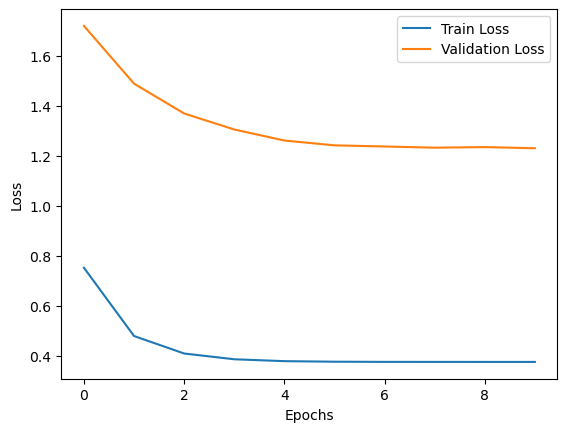

In [22]:
# Fit the baseline model
history = simple_mlp_model.fit(train_inputs, train_targets, validation_data=(test_inputs, test_targets), epochs=10, batch_size=1)

# Plot the learning curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# Evaluate the baseline model on the validation set
eval = simple_mlp_model.evaluate(val_inputs, val_targets)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3362 - mean_absolute_error: 0.74866


In [24]:
# LSTM model
lstm_model = Sequential([
    Input(shape=(train_inputs.shape[1], train_inputs.shape[2], train_inputs.shape[3])),
    Reshape(target_shape=(-1, train_inputs.shape[3])),
    #LSTM(4, kernel_regularizer=tf.keras.regularizers.l2(0.002), recurrent_dropout=0.2),
    LSTM(4, kernel_regularizer=tf.keras.regularizers.l2(0.002)),
    Dropout(0.2),
    Dense(54 * train_targets.shape[2]),
    Reshape(target_shape=(54, train_targets.shape[2]))
])

lstm_model.compile(loss='mean_squared_error', metrics=['mean_absolute_error'], optimizer=tf.keras.optimizers.Adam(0.001))

print(lstm_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 756, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 4)              │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 378)            │         1,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 54, 7)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,098 (8.20 KB)

 Trainable params: 2,098 (8.20 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 100s 99ms/step - loss: 0.6173 - mean_absolute_error: 0.4936 - val_loss: 1.2617 - val_mean_absolute_error: 0.6478
Epoch 2/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 96s 97ms/step - loss: 0.4280 - mean_absolute_error: 0.4043 - val_loss: 1.2307 - val_mean_absolute_error: 0.6510
Epoch 3/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 146s 100ms/step - loss: 0.3824 - mean_absolute_error: 0.3938 - val_loss: 1.1337 - val_mean_absolute_error: 0.6134
Epoch 4/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 139s 97ms/step - loss: 0.3623 - mean_absolute_error: 0.3741 - val_loss: 0.9807 - val_mean_absolute_error: 0.5407
Epoch 5/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 139s 94ms/step - loss: 0.3466 - mean_absolute_error: 0.3480 - val_loss: 0.8992 - val_mean_absolute_error: 0.5040
Epoch 6/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 149s 101ms/step - loss: 0.3026 - mean_absolute_error: 0.3214 - val_loss: 0.8598 - val_mean_absolute_error: 0.4922
Epoch 7/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 132s 92ms/step - loss: 0.2883 - mean_abso

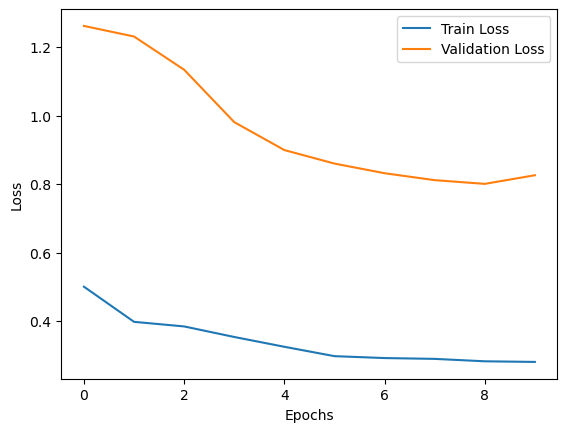

In [25]:
# Fit the model
history = lstm_model.fit(train_inputs, train_targets, validation_data=(test_inputs, test_targets), epochs=10, batch_size=1)

# Plot the learning curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# Evaluate the LSTM model on the validation set
eval = lstm_model.evaluate(val_inputs, val_targets)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.7761 - mean_absolute_error: 0.5272


In [27]:
# GRU model
gru_model = Sequential([
    Input(shape=(train_inputs.shape[1], train_inputs.shape[2], train_inputs.shape[3])),
    Reshape(target_shape=(-1, train_inputs.shape[3])),
    GRU(2, kernel_regularizer=tf.keras.regularizers.l2(0.002)),
    Dropout(0.2),
    Dense(54 * train_targets.shape[2]),
    Reshape(target_shape=(54, train_targets.shape[2]))
])

gru_model.compile(loss='mean_squared_error', metrics=['mean_absolute_error'], optimizer=tf.keras.optimizers.Adam(0.001))

print(gru_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)             │ (None, 756, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 2)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 378)            │         1,134 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 54, 7)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206 (4.71 KB)

 Trainable params: 1,206 (4.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 102s 101ms/step - loss: 0.7091 - mean_absolute_error: 0.5285 - val_loss: 1.3747 - val_mean_absolute_error: 0.6748
Epoch 2/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 140s 99ms/step - loss: 0.4030 - mean_absolute_error: 0.3943 - val_loss: 1.2892 - val_mean_absolute_error: 0.6651
Epoch 3/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 146s 103ms/step - loss: 0.3875 - mean_absolute_error: 0.3877 - val_loss: 1.1682 - val_mean_absolute_error: 0.6240
Epoch 4/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 137s 98ms/step - loss: 0.3708 - mean_absolute_error: 0.3752 - val_loss: 0.9897 - val_mean_absolute_error: 0.5369
Epoch 5/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 150s 106ms/step - loss: 0.3328 - mean_absolute_error: 0.3366 - val_loss: 0.8991 - val_mean_absolute_error: 0.5022
Epoch 6/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 148s 112ms/step - loss: 0.3017 - mean_absolute_error: 0.3200 - val_loss: 0.8555 - val_mean_absolute_error: 0.4910
Epoch 7/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 128s 98ms/step - loss: 0.2776 - mean_a

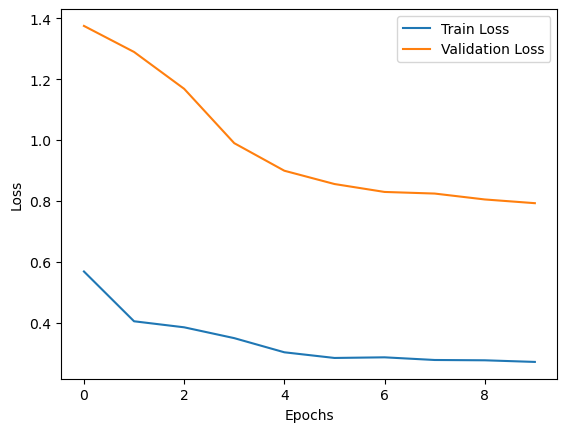

In [28]:
# Fit the model
history = gru_model.fit(train_inputs, train_targets, validation_data=(test_inputs, test_targets), epochs=10, batch_size=1)

# Plot the learning curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# Evaluate the GRU model on the validation set
eval = gru_model.evaluate(val_inputs, val_targets)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.7563 - mean_absolute_error: 0.5178
